In [71]:
import cv2
import h5py
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from toolz import concat
from tqdm.auto import tqdm

In [2]:
folders = [
    '/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_females',
    '/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_males',
    '/n/groups/datta/Dana/Ontogeny/raw_data/longtogeny_pre_unet/Females',
    '/n/groups/datta/Dana/Ontogeny/raw_data/longtogeny_pre_unet/Males',
]

folders = [Path(f) for f in folders]
files = sorted(concat(f.glob('**/results_00.h5') for f in folders))

In [73]:
training_data_path = Path('/n/groups/datta/win/longtogeny/data/size_network/training_data')

In [72]:
random.seed(0) 
samples = set(random.choices(files, k=50))

In [74]:
def isolate_noise(img):
    mask = (img < 20) & (img > 0)
    mask = cv2.morphologyEx(np.uint8(mask), cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=2)
    mask = cv2.morphologyEx(np.uint8(mask), cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=1)
    return mask

In [75]:
wall_noise = []
for file in tqdm(samples):
    with h5py.File(file, 'r') as h5f:
        frames = h5f['frames'][()]
        # QC 2
        mask = ~(np.median(frames, axis=0, keepdims=True) > 5)
        masked_frames = frames * mask
        noisy_frames = (masked_frames > 6).sum(axis=(1, 2))
    inds = np.argsort(noisy_frames)[::-1]
    noisy_inds = inds[noisy_frames[inds] > 700]
    wall_noise.extend([isolate_noise(f) * f for f in frames[noisy_inds]])
wall_noise = np.array(wall_noise)
num_pix = np.array([(w > 0).sum() for w in wall_noise])
wall_noise = wall_noise[num_pix > 75]

  0%|          | 0/50 [00:00<?, ?it/s]

In [91]:
len(wall_noise)

10127

In [92]:
with h5py.File(training_data_path / "wall_noise.h5", "w") as h5f:
    h5f.create_dataset("wall_frames", data=wall_noise, compression="gzip")

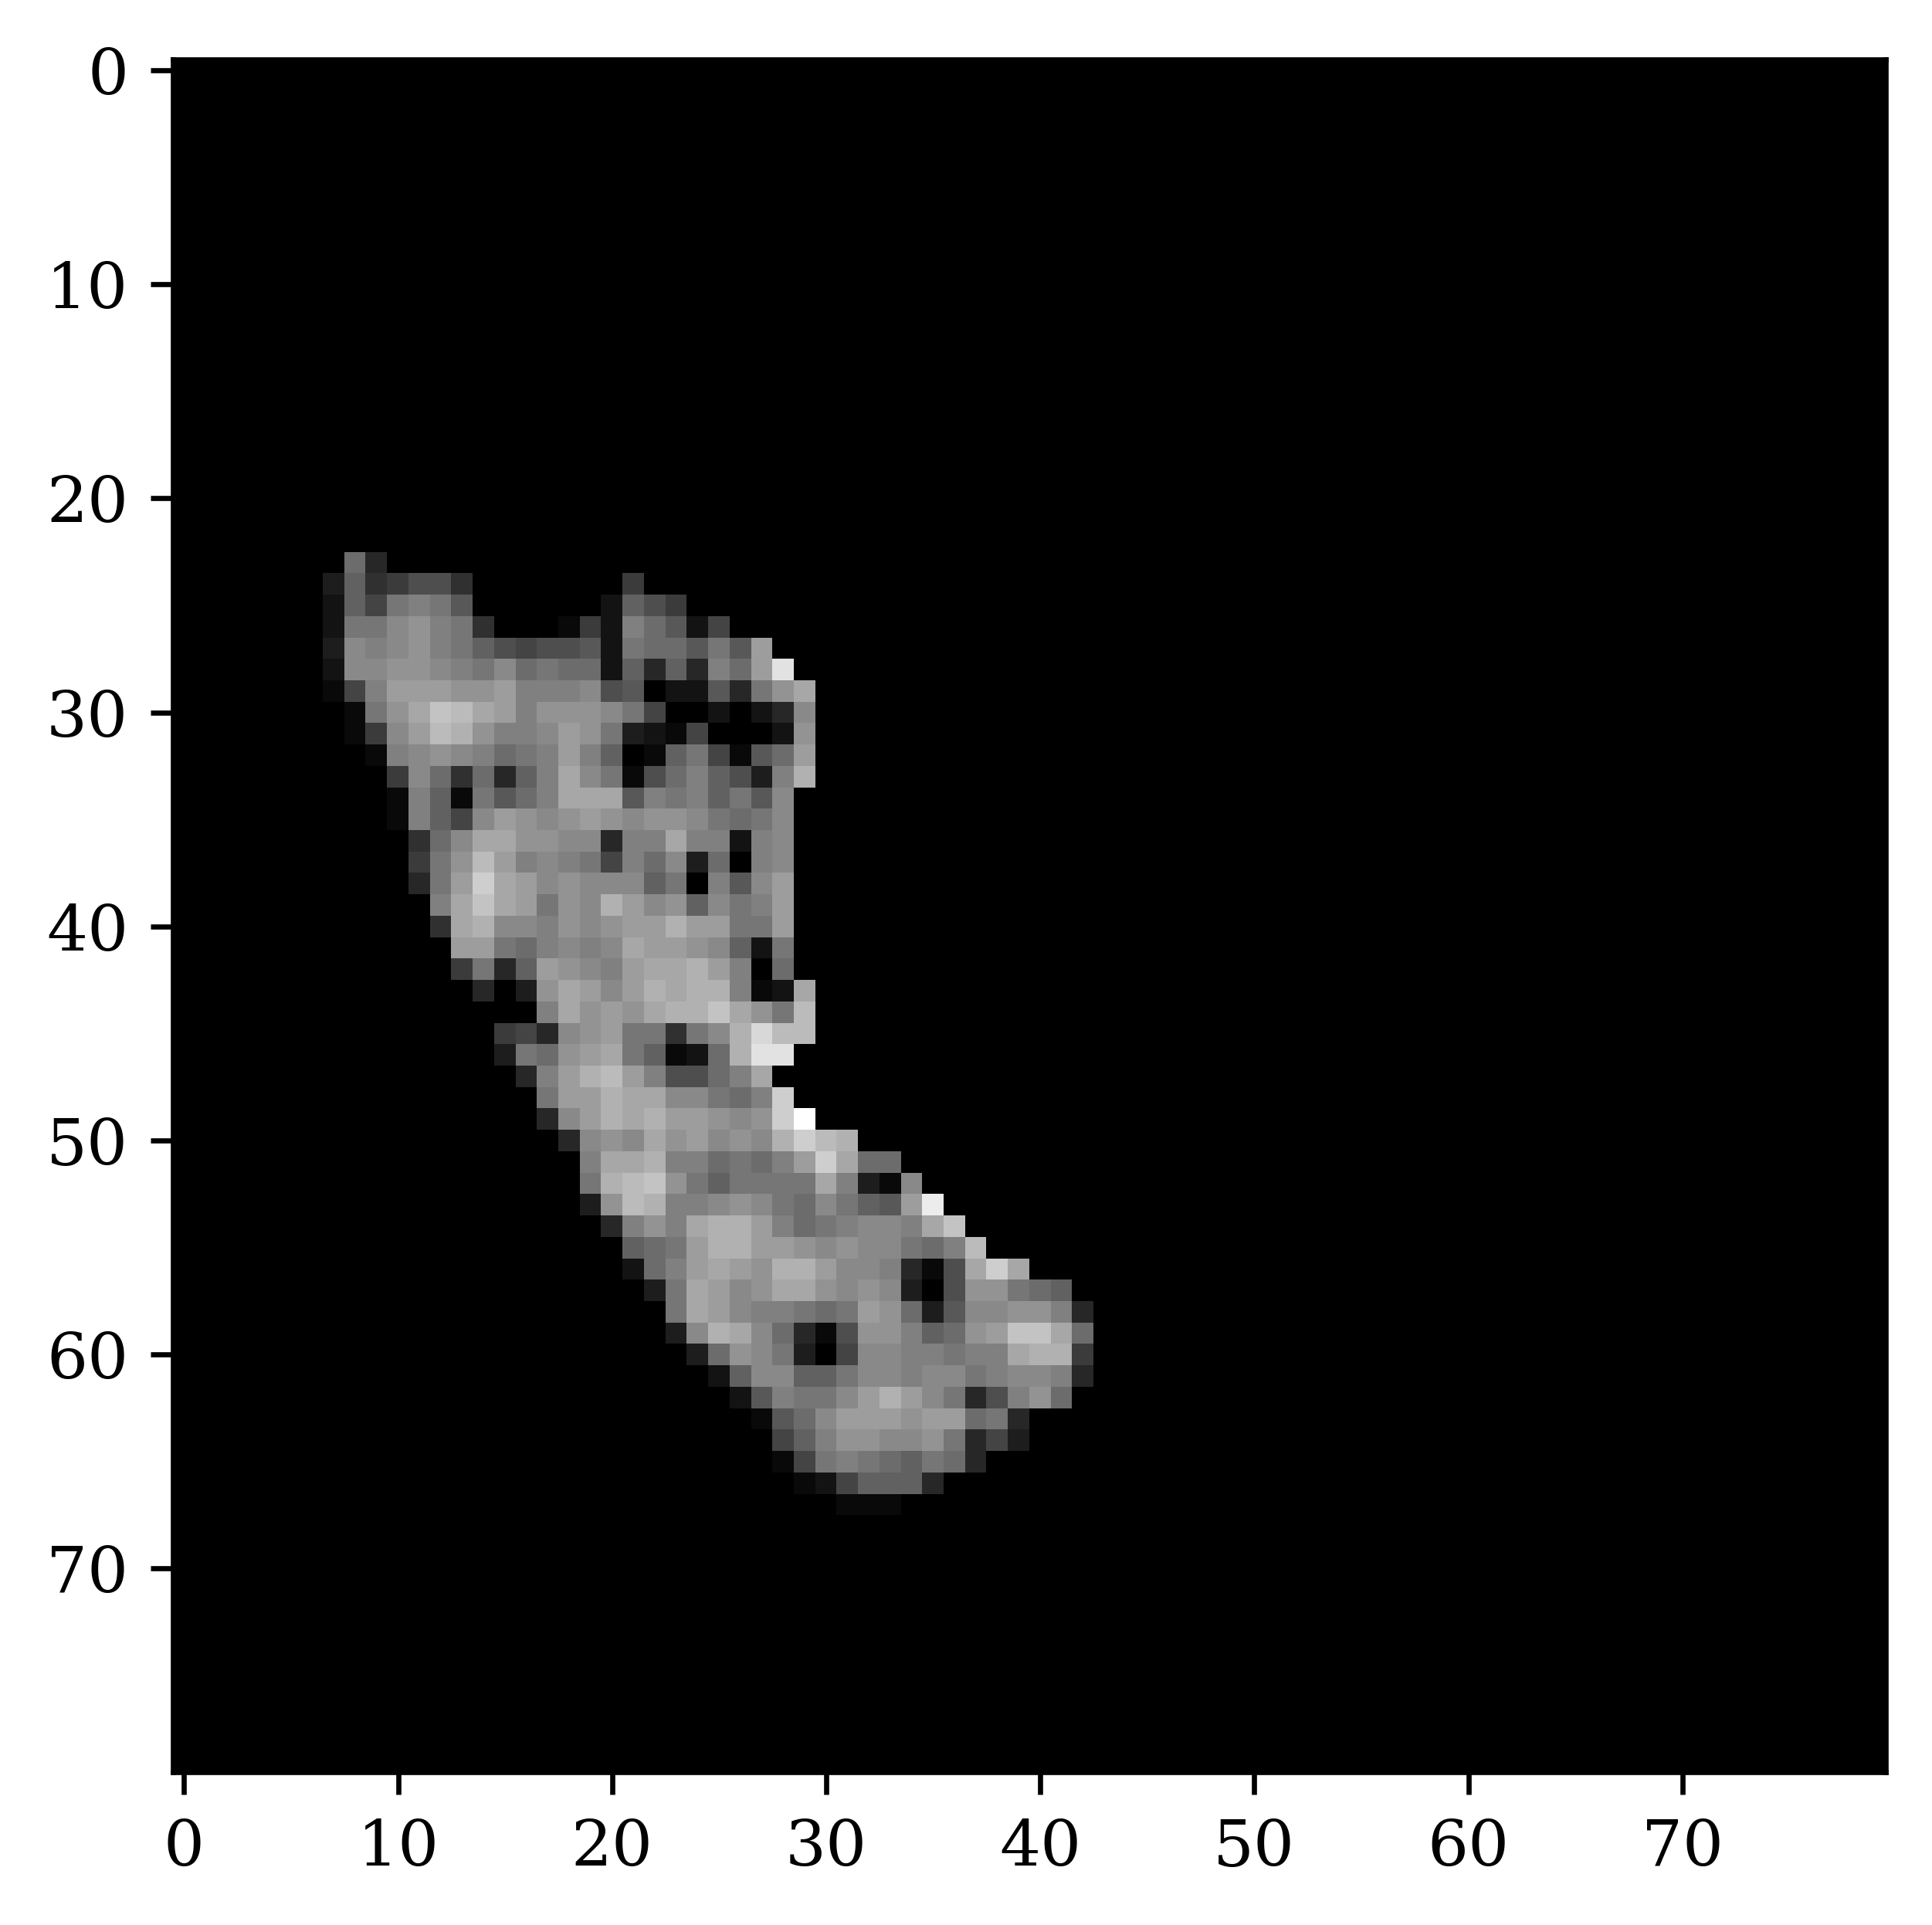

In [97]:
plt.imshow(wall_noise[2], cmap='gray')